# Практическое задание №2 "Масштабирование признаков. Регуляризация. Стохастический градиентный спуск".

1. Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.
2. Модифицировать решение первого задания путем добавления $L_{2}$-регуляризации (в функцию, считающую MSE добавить норму весов, а в поправку нужно добавить производную для нормы вектора весов по весам) и сравнить результаты.

In [1]:
from sklearn.datasets import make_regression
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mserror(X, w, y_pred):
    y = X.dot(w)
    return (sum((y - y_pred)**2)) / len(y)

## Задание 1

__Генерация датасета__

In [3]:
n_features = 2
n_objects = 10000

data, target = make_regression(n_samples=n_objects, n_features=n_features, random_state=128)

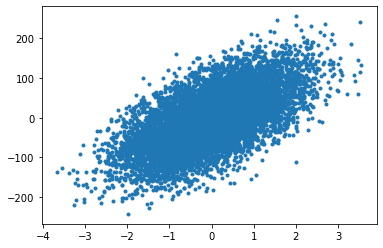

In [4]:
plt.plot(data[:,0], target, '.')
plt.show()

__Градиентный спуск__

In [5]:
np.random.seed(1234)
w = np.zeros(2)
eta = 0.01

max_iter = 1e4
min_weight_dist = 1e-4
weight_dist = np.inf
iter_num = 0

w_list = [w.copy()]
errors = []

In [6]:
while weight_dist > min_weight_dist and iter_num < max_iter:
    # новый вес w
    new_w = w - 2 * eta * np.dot(data.T, (np.dot(data, w) - target)) / target.shape[0]
    # оценка расстояния по эвклиду между старым и новым состоянием w
    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    # списки весов и ошибок
    w_list.append(new_w.copy())
    errors.append(mserror(data, new_w, target))
    
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)

In [7]:
errors_gd = errors
print(f'В случае использования градиентного спуска функционал ошибки составляет {round(errors_gd[-1], 4)}')

В случае использования градиентного спуска функционал ошибки составляет 0.0


__Стохастический градиентный спуск__

In [8]:
np.random.seed(1234)
w = np.zeros(2)
eta = 0.002
lamb = 0.01

max_iter = 1e5
min_weight_dist = 1e-8
weight_dist = np.inf
iter_num = 0

Q = [np.sum((np.dot(data, w) - target)**2)]
w_list = [w.copy()]

In [9]:
while weight_dist > min_weight_dist and iter_num < max_iter:
    train_ind = np.random.randint(data.shape[0])
    new_w = w - 2 * eta/1 * np.dot(data[train_ind].T, (np.dot(data[train_ind], w) - target[train_ind]))
    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    # списки весов, среднеквадратичной ошибки, функции ошибки 
    w_list.append(new_w.copy())
    Q.append(Q[-1] * (1 - lamb) + lamb * (np.dot(data[train_ind], w) - target[train_ind])**2)
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)

In [10]:
errors_sgd = Q
print(f'В случае использования стохастического градиентного спуска функционал ошибки составляет {round(errors_sgd[-1], 4)}')

В случае использования стохастического градиентного спуска функционал ошибки составляет 0.1641


__График__

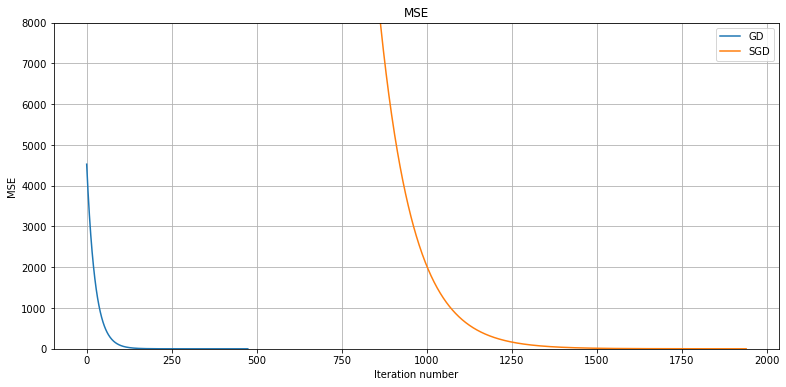

GD  MSE: 0.0
SGD MSE: 0.1641


In [11]:
plt.figure(figsize=(13, 6))
plt.plot(range(len(errors_gd[:2000])), errors_gd[:2000], label='GD')
plt.plot(range(len(errors_sgd[:2000])), errors_sgd[:2000], label='SGD')
# plt.plot(range(len(errors_gd)), errors_gd, label='GD')
# plt.plot(range(len(errors_sgd)), errors_sgd, label='SGD')
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.ylim([0, 8000])
plt.show()

print(f"GD  MSE: {round(errors_gd[-1], 4)}")
print(f"SGD MSE: {round(errors_sgd[-1], 4)}")

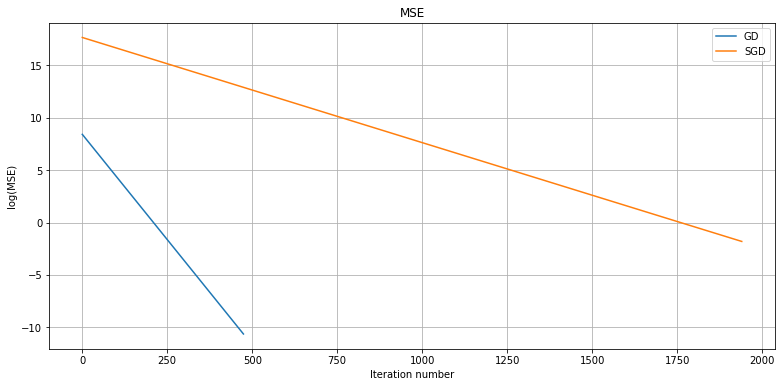

In [12]:
plt.figure(figsize=(13, 6))
plt.plot(range(len(errors_gd)), np.log(errors_gd), label='GD')
plt.plot(range(len(errors_sgd)), np.log(errors_sgd), label='SGD')
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('log(MSE)')
plt.grid(True)
# plt.ylim([-5, 19])
plt.legend()
plt.show()

__Вывод:__ График SGD менее плавный чем график обычного градиентного спуска, а также имеет намного более высокие начальные значения ошибки. Стохастческому градиентному спуску требуется большее количество итераций для достижения минимального значения ошибки. Однако, вычислительная сложность одного шага SGD ниже чем в GD.

Добиться лучшей скорости сходимости в методе SGD можно варьируя величину шага или используя методы, подбирающие ее адаптивно.

## Задание 2

__Стохастический градиентный спуск с добавлением $L_{2}$-регуляризации__

$$Q_{L2} = Q(w, X) + L(w)$$

$$\frac{\partial Q}{\partial w} = 2\cdot X^{T}(Xw-y)$$

$$\frac{\partial L}{\partial w} = 2\cdot \lambda w$$

$$w^{k} = w^{k-1} - \eta_{k}\nabla Q(w^{k-1}, \{x_{i}\})$$

$$w^{k} = w^{k-1} - \eta_{k} (2\cdot X^{T}(Xw-y) + 2\cdot \lambda w)$$

In [13]:
np.random.seed(1234)
w = np.zeros(2)

eta = 0.002
lamb = 0.1
# коэффициент регуляризации
q = 0.01

max_iter = 1e5
min_weight_dist = 1e-8
weight_dist = np.inf
iter_num = 0

Q = [np.sum((np.dot(data, w) - target)**2)]
w_list = [w.copy()]

In [14]:
while weight_dist > min_weight_dist and iter_num < max_iter:
    # генерируем случайный индекс объекта выборки
    train_ind = np.random.randint(data.shape[0])
    
    # производная потерь, состоит из 2 частей
    dQ = 2 * np.dot(data[train_ind].T, (np.dot(data[train_ind], w) - target[train_ind]))
    dL2 = 2 * q * w
    
    # новые веса
    new_w = w - eta * (dQ + dL2)
    
    # расстояние по эвклиду
    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    # списки
    w_list.append(new_w.copy())
    new_q = Q[-1]*(1 - lamb) + lamb*(np.dot(data[train_ind], w) - target[train_ind])**2 + q*np.sum(w**2)
    Q.append(new_q)
    
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)

In [15]:
errors_sgd_l2 = Q
print(f'В случае использования стохастического градиентного спуска функционал ошибки составляет {round(errors_sgd_l2[-1], 4)}')

В случае использования стохастического градиентного спуска функционал ошибки составляет 464.9613


__Сравнение результатов__

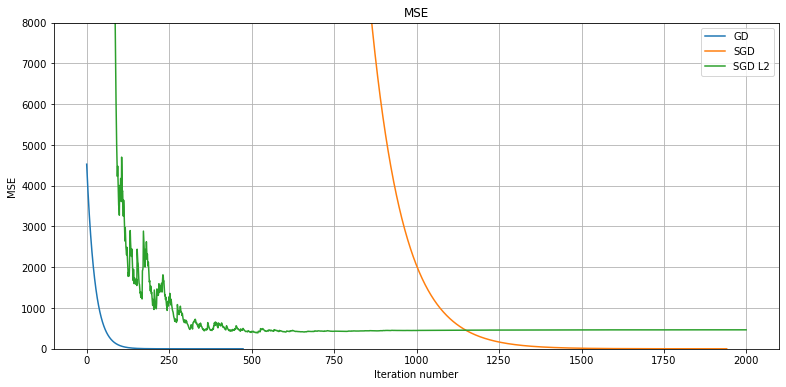

GD  MSE: 0.0
SGD MSE: 0.1641
SGD MSE: 464.9613


In [16]:
plt.figure(figsize=(13, 6))
plt.plot(range(len(errors_gd[:2000])), errors_gd[:2000], label='GD')
plt.plot(range(len(errors_sgd[:2000])), errors_sgd[:2000], label='SGD')
plt.plot(range(len(errors_sgd_l2[:2000])), errors_sgd_l2[:2000], label='SGD L2')
# plt.plot(range(len(errors_gd)), errors_gd, label='GD')
# plt.plot(range(len(errors_sgd)), errors_sgd, label='SGD')
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.ylim([0, 8000])
plt.show()

print(f"GD  MSE: {round(errors_gd[-1], 4)}")
print(f"SGD MSE: {round(errors_sgd[-1], 4)}")
print(f"SGD MSE: {round(errors_sgd_l2[-1], 4)}")

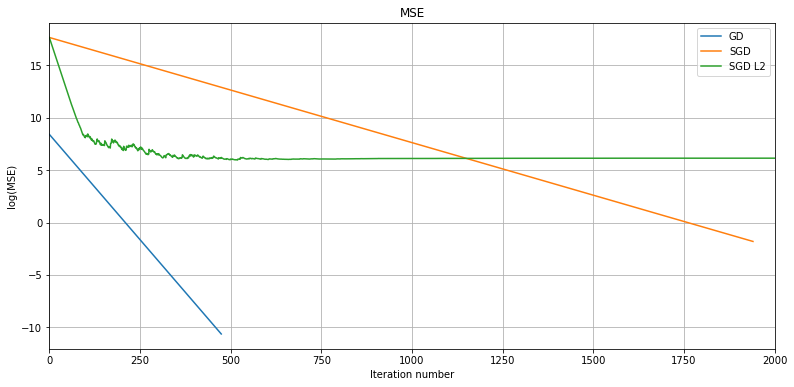

In [17]:
plt.figure(figsize=(13, 6))
plt.plot(range(len(errors_gd)), np.log(errors_gd), label='GD')
plt.plot(range(len(errors_sgd)), np.log(errors_sgd), label='SGD')
plt.plot(range(len(errors_sgd_l2)), np.log(errors_sgd_l2), label='SGD L2')
plt.xlim([0, 2000])
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('log(MSE)')
plt.grid(True)
plt.legend()
plt.show()

__Вывод:__ По графику видно, что в случае использования стохастического градиентного спуска с L2- регуляризацией конечный функционал ошибки выше. Также видно, что с регуляризацией повысилась скорость сходимости.

Последствия регуляризации $L_{2}$:
* Скорость сходимости увеличилась
* Функционал ошибки стал увеличился 

---